# Plot behavioral test performance

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mindstorm import statplot
from bender_study import task
from bender_study import figures

bids_dir = Path(os.environ['BENDER_BIDS']) / 'rawdata'
fig_dir = Path(os.environ['BENDER_FIGURES']) / 'plots'
figures.set_style()

## Load data and calculate statistics

In [2]:
data = task.load_test_events(bids_dir)

In [3]:
trials = ['subject', 'trial_type']
grp = data.groupby(trials)
m = grp[['pair_type']].first()
m['correct'] = grp['correct'].mean()
m['correct_rt'] = (
    data.query('correct == 1')
    .groupby(trials)['response_time']
    .mean()
)
m['incorrect_rt'] = (
    data.query('correct == 0')
    .groupby(trials)['response_time']
    .mean()
)
m.head(8)

pair_type   correct  correct_rt  incorrect_rt
subject trial_type                                              
02      AB1               AB  0.781513    1.681763      1.838962
        AB2               AB  0.925000    1.213730      1.841000
        AB3               AB  0.983333    1.132059      1.355000
        AB4               AB  1.000000    1.120558           NaN
        AC                AC  0.661017    3.343590      4.065450
        BC                BC  0.891667    2.372103      3.325154
        XY                XY  0.816667    2.753816      3.156636
        AB                AB  0.991667    1.769664      4.084000

## Plot response accuracy

In [4]:
dark = sns.color_palette(
    [
        (0.0471, 0.7451, 0.3059),
        (0.0000, 0.5451, 1.0000),
        (1.0000, 0.6510, 0.1647),
        (1.0000, 0.2784, 0.5647),
    ]
)

dark

[(0.0471, 0.7451, 0.3059),
 (0.0, 0.5451, 1.0),
 (1.0, 0.651, 0.1647),
 (1.0, 0.2784, 0.5647)]

In [5]:
light = sns.color_palette(
    [
        (0.4549, 0.8471, 0.6078),
        (0.4863, 0.7804, 1.0000),
        (1.0000, 0.8196, 0.6039),
        (1.0000, 0.5961, 0.8275),
    ]
)
light

[(0.4549, 0.8471, 0.6078),
 (0.4863, 0.7804, 1.0),
 (1.0, 0.8196, 0.6039),
 (1.0, 0.5961, 0.8275)]

LINO NOT subset; don't know how to subset; dropped


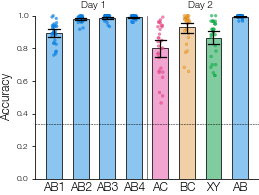

In [6]:
with plt.style.context({'font.size': 10}):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax = statplot.plot_swarm_bar(
        data=m,
        x='trial_type',
        y='correct',
        hue='pair_type',
        light=light,
        dark=dark,
        point_kind='strip',
        width=.6,
        legend=False,
        ax=ax,
    )
    ax.axline((0, 1/3), slope=0, color='k', linestyle='--', linewidth=.5)
    ax.axline((3.5, 0), slope=np.Inf, color='k', linestyle='-', linewidth=.5)
    ax.set(ylim=(0, 1.0), ylabel='Accuracy')
    ax.tick_params(axis='x', length=0)
    
    fontdict = {'horizontalalignment': 'center'}
    ax.text(1.5, 1.05, 'Day 1', fontdict=fontdict)
    ax.text(5.5, 1.05, 'Day 2', fontdict=fontdict);
    
    ax.figure.savefig(fig_dir / 'accuracy.pdf')

## Plot response times for correct responses

LINO NOT subset; don't know how to subset; dropped


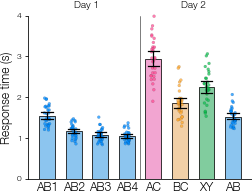

In [7]:
with plt.style.context({'font.size': 10}):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax = statplot.plot_swarm_bar(
        data=m,
        x='trial_type',
        y='correct_rt',
        hue='pair_type',
        light=light,
        dark=dark,
        point_kind='strip',
        width=.6,
        legend=False,
        ax=ax,
    )
    ax.axline((3.5, 0), slope=np.Inf, color='k', linestyle='-', linewidth=.5)
    ax.set(ylim=(0, 4), ylabel='Response time (s)')
    ax.tick_params(axis='x', length=0)
    
    fontdict = {'horizontalalignment': 'center'}
    ax.text(1.5, 4.2, 'Day 1', fontdict=fontdict)
    ax.text(5.5, 4.2, 'Day 2', fontdict=fontdict);
    
    ax.figure.savefig(fig_dir / 'rt.pdf')

In [8]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

bender_study: 0.1.0
matplotlib  : 3.5.1
mindstorm   : 0.8.1
numpy       : 1.22.3
seaborn     : 0.11.2

